### Star, Galaxy, or Quasar?

![alt text](https://www.sdss.org/wp-content/uploads/2014/05/segue.jpg)


In this problem, we will use a Pytorch logististic regression model to predict whether an observed object is a star, galaxy, or quasar.

**The Data**

We will be using data collected by the Sloan Digital Sky Survey ([SDSS](http://www.sdss.org/)) and released as part of Data Release 14. SDSS is a multi-spectral and spectroscopic survey telescope at Apache Point Observatory in New Mexico, USA. 

The telescope uses a camera of 30 CCDs which observe in different optical filter bands (u,g,r,i,z). The data used here is freely publicly available. 

Therefore we will be importing a table of 10,000 objects, for each of which we have the following information:
- class = tells us whether the object is a GALAXY, STAR, or QSO ("quasi-stellar object" or [quasar](https://en.wikipedia.org/wiki/Quasar))
- ra = [Right Ascension](https://en.wikipedia.org/wiki/Right_ascension)
- dec = Declination 
- [redshift](https://en.wikipedia.org/wiki/Redshift)


Magnitude in each of the following [filters](http://skyserver.sdss.org/dr1/en/proj/advanced/color/sdssfilters.asp):
- u
- g
- r
- i
- z


The data we will be using in this exercise has already been preprocessed in the following ways:
- The 'class' feature has been converted to a set of labels (target array) `T`. Here, 0, 1, and 2 correspond to STAR, GALAXY, and QUASAR respectively.
- The rest of the features have been converted to a scaled array `X`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch

In [2]:
# Let's import the processed data
!wget https://raw.githubusercontent.com/ChristiaanvA/ml4pha_datasets/main/Skyserver_SQL_labels.csv
!wget https://raw.githubusercontent.com/ChristiaanvA/ml4pha_datasets/main/Skyserver_SQL_features.csv

--2023-03-21 11:22:07--  https://raw.githubusercontent.com/ChristiaanvA/ml4pha_datasets/main/Skyserver_SQL_labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250000 (244K) [text/plain]
Saving to: ‘Skyserver_SQL_labels.csv’

Skyserver_SQL_label 100%[===================>] 244.14K  --.-KB/s    in 0.03s   

2023-03-21 11:22:07 (7.49 MB/s) - ‘Skyserver_SQL_labels.csv’ saved [250000/250000]

--2023-03-21 11:22:07--  https://raw.githubusercontent.com/ChristiaanvA/ml4pha_datasets/main/Skyserver_SQL_features.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaitin

In [3]:
T = pd.read_csv('/content/Skyserver_SQL_labels.csv').rename(columns = {'0.000000000000000000e+00':'label'})
T = pd.get_dummies(T, columns = ['label'])
T = T.to_numpy().flatten().reshape(len(T), 3)
X = pd.read_csv('/content/Skyserver_SQL_features.csv').to_numpy()

First, we shuffle our X and T arrays, in such a way that each row still corresponds to each row! We split your target array `T` into two arrays: `T_train` and `T_test` and corresponding two `X_train` and `X_test` arrays, where the train test contains 90% of the datapoints and the test dataset contains 10% of the datapoints.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, T_train, T_test = train_test_split(X, T, test_size = 0.33, shuffle = True)#, random_state=1)

In [5]:
X_train_tensor = torch.from_numpy(X_train).to(torch.float)
T_train_tensor = torch.from_numpy(T_train).to(torch.float)

X_test_tensor = torch.from_numpy(X_test).to(torch.float)
T_test_tensor = torch.from_numpy(T_test).to(torch.float)

In [6]:
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(8,3)
        self.softmax = torch.nn.Softmax(dim = 1)

    def forward(self,x):
        y = self.softmax(self.linear(x))
        return y

In [7]:
model = LogisticRegression()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

In [8]:
model.train()
loss_history = []
for epoch in range(15000):
    optimizer.zero_grad()

    # forward pass
    Y_pred = model(X_train_tensor)

    # compute loss
    loss = criterion(Y_pred, T_train_tensor)
    if epoch% 1000 == 0:
        print(loss.item())
        loss_history.append(loss.item())
    # backward pass
    loss.backward()
    optimizer.step()

1.1589226722717285
0.8460386991500854
0.8013460636138916
0.7823293209075928
0.7706000208854675
0.7620438933372498
0.7552009224891663
0.7494094371795654
0.7443205118179321
0.7397312521934509
0.7355144619941711
0.7315869927406311
0.7278916239738464
0.7243873476982117
0.7210433483123779


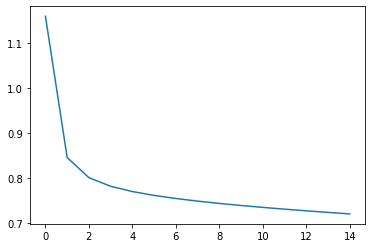

In [9]:
plt.plot(loss_history)

We will define the function `accuracy` which takes as inputs the targets and the predictions by the model and use it to evaluate the accuracy of our logistic regression model on the train and test datasets.

In [10]:
y_pred = model(X_test_tensor)
def accuracy(y_pred, T_test):
  y_pred = y_pred.cpu().detach().numpy()
  pred = []
  t_test = []
  for i in range(len(y_pred)):
    maximum_y = max(y_pred[i])
    maximum_T = max(T_test[i])
    pred.append(np.where(y_pred[i] == maximum_y))
    t_test.append(np.where(T_test[i] == maximum_T))
  pred = np.array(pred)
  t_test = np.array(t_test)

  c = 0
  for i in range(len(t_test)):
    if pred[i] == t_test[i]:
      c+=1

  acc = c/len(T_test)

  return acc


In [11]:
acc = accuracy(y_pred, T_test)
print('Model accuracy = ',np.round(acc, 3))

Model accuracy =  0.875
